In [1]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

from pathlib import Path
import numpy as np
import pandas as pd

from scipy.stats import spearmanr

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape, BatchNormalization
import tensorflow.keras.backend as K

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [2]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
    # tf.config.experimental.set_virtual_device_configuration(gpu_devices[0],
    # [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024*6)])
else:
    print('Using CPU')

idx = pd.IndexSlice

sns.set_style('whitegrid')
np.random.seed(42)

results_path = Path('results', 'lstm_embeddings')
if not results_path.exists():
    results_path.mkdir(parents=True)

Using GPU


In [3]:
data = pd.read_hdf('rnn_data.h5', 'returns_weekly').drop('label', axis=1)
data['ticker'] = pd.factorize(data.index.get_level_values('ticker'))[0]
data['month'] = data.index.get_level_values('date').month
data = pd.get_dummies(data, columns=['month'], prefix='month')
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 1167341 entries, ('A', Timestamp('2009-01-11 00:00:00')) to ('ZUMZ', Timestamp('2017-12-31 00:00:00'))
Data columns (total 66 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   fwd_returns  1167341 non-null  float64
 1   1            1167341 non-null  float64
 2   2            1167341 non-null  float64
 3   3            1167341 non-null  float64
 4   4            1167341 non-null  float64
 5   5            1167341 non-null  float64
 6   6            1167341 non-null  float64
 7   7            1167341 non-null  float64
 8   8            1167341 non-null  float64
 9   9            1167341 non-null  float64
 10  10           1167341 non-null  float64
 11  11           1167341 non-null  float64
 12  12           1167341 non-null  float64
 13  13           1167341 non-null  float64
 14  14           1167341 non-null  float64
 15  15           1167341 non-null  float64
 16  16           1167

In [4]:
data.tail()

fwd_returns         1         2         3         4  \
ticker date                                                              
ZUMZ   2017-12-03     0.047244  0.007937  0.000000  0.058824 -0.005571   
       2017-12-10     0.062657  0.047244  0.007937  0.000000  0.058824   
       2017-12-17    -0.051887  0.062657  0.047244  0.007937  0.000000   
       2017-12-24     0.067164 -0.051887  0.062657  0.047244  0.007937   
       2017-12-31    -0.029138  0.067164 -0.051887  0.062657  0.047244   

                          5         6         7         8         9  ...  \
ticker date                                                          ...   
ZUMZ   2017-12-03  0.016997  0.029155 -0.065395  0.013812  0.100304  ...   
       2017-12-10 -0.005571  0.016997  0.029155 -0.065395  0.013812  ...   
       2017-12-17  0.058824 -0.005571  0.016997  0.029155 -0.065395  ...   
       2017-12-24  0.000000  0.058824 -0.005571  0.016997  0.029155  ...   
       2017-12-31  0.007937  0.000000  0.058824 -0.005571  0.016997  ...   

                   month_3  month_4  month_5  month_6  month_7  month_8  \
ticker date                                                               
ZUMZ   2017-12-03        0        0        0        0        0        0   
       2017-12-10        0        0        0        0        0        0   
       2017-12-17        0        0        0        0        0        0   
       2017-12-24        0        0        0        0        0        0   
       2017-12-31        0        0        0        0        0        0   

                   month_9  month_10  month_11  month_12  
ticker date                                               
ZUMZ   2017-12-03        0         0         0         1  
       2017-12-10        0         0         0         1  
       2017-12-17        0         0         0         1  
       2017-12-24        0         0         0         1  
       2017-12-31        0         0         0         1  

[5 rows x 66 columns]

In [5]:
# Train-test split
window_size=52
sequence = list(range(1, window_size+1))
ticker = 1
months = 12
n_tickers = data.ticker.nunique()
train_data = data.loc[idx[:, :'2016'], :]
test_data = data.loc[idx[:, '2017'],:]

In [6]:
X_train = [
    train_data.loc[:, sequence].values.reshape(-1, window_size , 1),
    train_data.ticker,
    train_data.filter(like='month')
]
y_train = train_data.fwd_returns # fwd_returns for regression usage instead of binary label
[x.shape for x in X_train], y_train.shape

([(1035424, 52, 1), (1035424,), (1035424, 12)], (1035424,))

In [7]:
# keep the last year for testing
X_test = [
    test_data.loc[:, list(range(1, window_size+1))].values.reshape(-1, window_size , 1),
    test_data.ticker,
    test_data.filter(like='month')
]
y_test = test_data.fwd_returns
[x.shape for x in X_test], y_test.shape

([(131917, 52, 1), (131917,), (131917, 12)], (131917,))

In [8]:
K.clear_session()
n_features = 1
returns = Input(shape=(window_size, n_features), name='Returns')
tickers = Input(shape=(1,), name='Tickers')
months = Input(shape=(12,), name='Months')

In [9]:
# LSTM Layers
lstm1_units = 25
lstm2_units = 10
lstm1 = LSTM(units=lstm1_units, input_shape=(window_size, n_features), name='LSTM1', dropout=.2,
             return_sequences=True)(returns)

lstm_model = LSTM(units=lstm2_units, dropout=.2, name='LSTM2')(lstm1)

In [10]:
# Embedding Layer
ticker_embedding = Embedding(input_dim=n_tickers, output_dim=5, input_length=1)(tickers)
ticker_embedding = Reshape(target_shape=(5,))(ticker_embedding)

In [11]:
# Concatenate Model components
merged = concatenate([lstm_model, ticker_embedding, months], name='Merged')

bn = BatchNormalization()(merged)
hidden_dense = Dense(10, name='FC1')(bn)

output = Dense(1, name='Output')(hidden_dense)

rnn = Model(inputs=[returns, tickers, months], outputs=output)

In [12]:
rnn.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Returns (InputLayer)           [(None, 52, 1)]      0           []                               
                                                                                                  
 Tickers (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 LSTM1 (LSTM)                   (None, 52, 25)       2700        ['Returns[0][0]']                
                                                                                                  
 embedding (Embedding)          (None, 1, 5)         12445       ['Tickers[0][0]']                
                                                                                              

In [13]:
# Train the Model
optimizer =tf.keras.optimizers.Adam()

rnn.compile(loss='mse', optimizer=optimizer)
lstm_path = (results_path / 'lstm.regression.h5').as_posix()

checkpointer = ModelCheckpoint(filepath=lstm_path, verbose=1, monitor='val_loss', mode='min',
                               save_best_only=True)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
training = rnn.fit(X_train, y_train, epochs=50, batch_size=64, validation_data=(X_test, y_test),
                   callbacks=[early_stopping, checkpointer], verbose=1, workers=6)

Epoch 1/50
16179/16179 [==============================] - ETA: 0s - loss: 0.0056
Epoch 00001: val_loss improved from inf to 0.00159, saving model to results/lstm_embeddings\lstm.regression.h5
16179/16179 [==============================] - 174s 10ms/step - loss: 0.0056 - val_loss: 0.0016
Epoch 2/50
16174/16179 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 00002: val_loss improved from 0.00159 to 0.00159, saving model to results/lstm_embeddings\lstm.regression.h5
16179/16179 [==============================] - 165s 10ms/step - loss: 0.0029 - val_loss: 0.0016
Epoch 3/50
16175/16179 [============================>.] - ETA: 0s - loss: 0.0029
Epoch 00003: val_loss improved from 0.00159 to 0.00154, saving model to results/lstm_embeddings\lstm.regression.h5
16179/16179 [==============================] - 165s 10ms/step - loss: 0.0029 - val_loss: 0.0015
Epoch 4/50
16174/16179 [============================>.] - ETA: 0s - loss: 0.0028
Epoch 00004: val_loss improved from 0.00154 to 

In [15]:
loss_history = pd.DataFrame(training.history)

# Evaluate model performance
test_predict = pd.Series(rnn.predict(X_test).squeeze(), index=y_test.index)
df = y_test.to_frame('ret').assign(y_pred=test_predict)
by_date = df.groupby(level='date')
df['deciles'] = by_date.y_pred.apply(pd.qcut, q=5, labels=False, duplicates='drop') # y_pred divides 5 deciles
ic = by_date.apply(lambda x: spearmanr(x.ret, x.y_pred)[0]).mul(100)
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 131917 entries, ('A', Timestamp('2017-01-01 00:00:00')) to ('ZUMZ', Timestamp('2017-12-31 00:00:00'))
Data columns (total 3 columns):
 #   Column   Non-Null Count   Dtype  
---  ------   --------------   -----  
 0   ret      131917 non-null  float64
 1   y_pred   131917 non-null  float32
 2   deciles  131917 non-null  int64  
dtypes: float32(1), float64(1), int64(1)
memory usage: 3.1+ MB


In [16]:
test_predict = test_predict.to_frame('prediction')
test_predict.index.names = ['symbol', 'date']
test_predict.to_hdf(results_path / 'predictions.h5', 'predictions')
rho, p = spearmanr(df.ret, df.y_pred)
print(f'{rho*100:.2f} ({p:.2%})')

3.77 (0.00%)


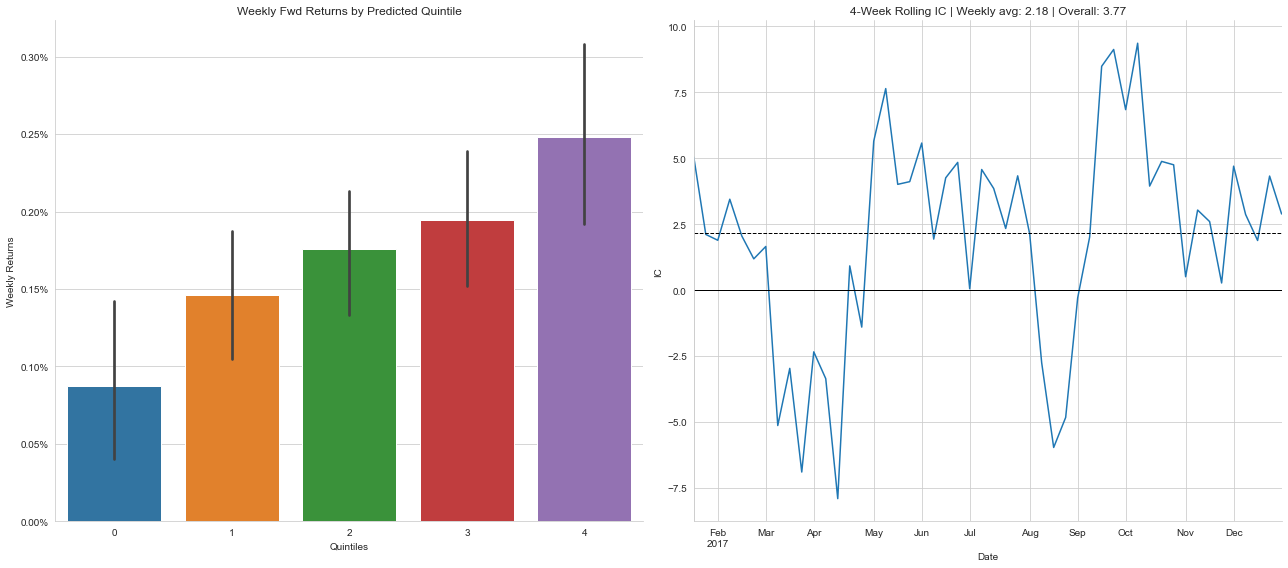

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(18,8))
sns.barplot(x='deciles', y='ret', data=df, ax=axes[0])
axes[0].set_title('Weekly Fwd Returns by Predicted Quintile')
axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.2%}'.format(y)))
axes[0].set_ylabel('Weekly Returns')
axes[0].set_xlabel('Quintiles')

avg_ic = ic.mean()
title = f'4-Week Rolling IC | Weekly avg: {avg_ic:.2f} | Overall: {rho*100:.2f}'
ic.rolling(4).mean().dropna().plot(ax=axes[1], title=title)
axes[1].axhline(avg_ic, ls='--', c='k', lw=1)
axes[1].axhline(0, c='k', lw=1)
axes[1].set_ylabel('IC')
axes[1].set_xlabel('Date')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'lstm_reg');